# Actor-Critic methods

The REINFORCE algorithm is generally implemented as an episodic algorithm,
meaning that we only apply it to update our model parameters after the agent has
completed an entire episode (and collected rewards along the way).
By sampling a full episode, we get a pretty good idea of the true value of an action
because we can see its downstream effects rather than just its immediate effect (which
may be misleading due to randomness in the environment); this full episode sampling
is under the umbrella of _Monte Carlo_ approaches.  The advantage of this method is that
it’s unbiased. Since we’re not estimating the return, we use only the true return we
obtain. However, given the stochasticity of the environment (random events during an
episode) and stochasticity of the policy, trajectories can lead to different returns,
which can lead to high variance. Consequently, the same starting state can lead to very
different returns. In a Monte Carlo approach, high _variance_ leads to slower training since we need a lot of
samples to mitigate it.

There are two challenges we want to overcome to
increase the robustness of the policy learner:
- We want to improve the sample efficiency by updating more frequently.
- We want to decrease the variance of the reward we used to update our model.

These problems are related, since the reward variance depends on how many samples
we collect (more samples yields less variance). 
To address these challenges, we introduce **Actor-Critic** methods, a hybrid architecture combining value-based and policy-based methods that helps to stabilize the training by reducing the variance using:

- An _Actor_, represented by a function $\pi_\theta(s)$ that controls how our agent behaves (policy-based method)
- A _Critic_, represented by the function $q_w(s,a)$ that measures how good the taken
  action is (value-based method)

The idea behind a combined value-policy
algorithm is to use the **value learner** to reduce the **variance** in the rewards that are
used to train the policy.

The Actor-Critic process works like this:
1. The Actor (policy) takes the current state $s_t$ and outputs an action $a_t$.
2. The Critic computes $q_w(s_t,a_t)$.
3. The action $a_t$ performed in the environment outputs a new state $s_{t+1}$ and a
   reward $r_{t+1}$.
4. The Actor updates its policy parameters using $q_w(s_t,a_t)$.

<figure>
    <img src="step4_ac.png" alt="Caption" width="800" />
    <figcaption>Update of the policy parameters (taken from huggingface.co).</figcaption>
</figure>

5. With the updated parameters, the Actor produces the next action $a_{t+1}$ to
   take given the new state $s_{t+1}$.

6. The Critic then updates its value parameters to minimize the MSE between the Q-value
   of $(s_t,a_t)$, i.e. $r_{t+1}+\gamma q_w(s_{t+1},a_{t+1})$, and the corresponding
   estimate of the network, i.e. $q_w(s_{t},a_{t})$:

<figure>
    <img src="step5_ac.png" alt="Caption" width="800" />
    <figcaption>Update of the critic parameters (taken from huggingface.co).</figcaption>
</figure>

We can stabilize learning further by using the **Advantage Function** $A(s,a)$ instead
of the action-value function in the policy loss. We call this method **Advantage Actor
Critic** (A2C). The Advantage Function calculates the relative advantage of an action compared to
the others
possible at a state:

$$ A(s,a) = q_w(s,a) - v(s) $$

with $v(s)$ the state-value function.  In other words, this function calculates the extra reward we get if we take this action at that state compared to the mean reward we get at that state.

- If $A(s,a) > 0$: our gradient is pushed in that direction.
- If $A(s,a) < 0$ (our action does worse than the average value of that state), our gradient is pushed in the opposite direction.

We replace $q_w(s,a)$ in step 4 above with $A(s,a)$. To avoid using both $q_w(s,a)$ and
$v(s)$ in steps 4 and 6, we can estimate $q_w(s_t,a_t)$ as $r_{t+1} + \gamma
v(s_{t+1})$.

<figure>
    <img src="ac_scheme.png" alt="Caption" width="800" />
    <figcaption>The general overview of actor-critic methods (taken from "Deep Reinforcement Learning in Action")<figcaption>
</figure>

### Proximal Policy Optimization (PPO)

The idea with Proximal Policy Optimization (PPO) is that we want to improve the training stability of the policy by limiting the change you make to the policy at each training epoch: we want to avoid having too large of a policy update.

To do so, we need to measure how much the current policy changed compared to the former one using a ratio calculation between the current and former policy. And we clip this ratio in a range
$[1−\epsilon,1+\epsilon]$, meaning that we remove the incentive for the current policy
to go too far from the old one (hence the proximal policy term).

You can read more about this [here](https://huggingface.co/learn/deep-rl-course/unit8/clipped-surrogate-objective).

## Using Stable Baselines JAX (SBX)

[`Stable-Baselines3`](https://stable-baselines3.readthedocs.io/en/master/) is a set of
reliable implementations of reinforcement learning algorithms in PyTorch. `SBX` (Stable
Baselines JAX) is the JAX
porting of such a library.

Study the documentation of SBX and solve the following environments using PPO:
- `CartPole-v1`
- `LunarLander-v2`
- `Pendulum-v1`
- `Acrobot-v1`
- `Reacher-v2`
- `Ant`

You may need to adjust the hyperparameters, such as `learning_rate` and
`total_timesteps`.

Check the
[`Logger`](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger)
documentation on how to log training data. Use the log data contained in a `csv` file to
make a plot of the _average reward per episode_.

After training a model, play 1000 games using the learned policy and compute the average total reward per game.

In [1]:
import gymnasium as gym
# from sbx import PPO
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure

environment = "CartPole-v1"
params_cartpole = {}

In [4]:
def train(env_name, algo_params, total_timesteps=10000, progress_bar=True):
    env = gym.make(env_name)
    tmp_path = "tmp/sb3_log/"
    logger = configure(tmp_path, ["csv"])

    model = PPO("MlpPolicy", env, **algo_params)
    model.set_logger(logger)
    model.learn(total_timesteps=total_timesteps, progress_bar=progress_bar)

    return model

In [5]:
model = train(environment, params_cartpole, total_timesteps=5e5)

Output()

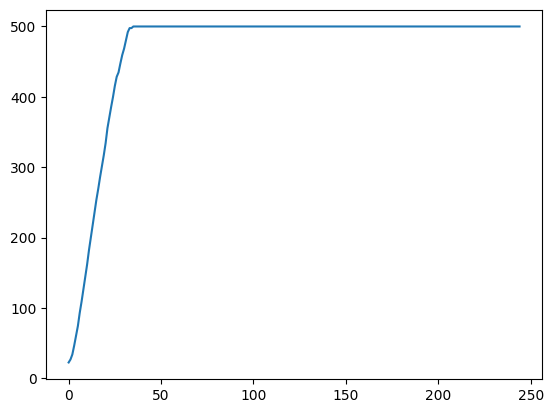

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("tmp/sb3_log/progress.csv")

ep_rew_mean = df["rollout/ep_rew_mean"].to_numpy()
plt.plot(ep_rew_mean)
plt.show()

In [7]:
import numpy as np

def play(env_name, model, num_games=1, max_actions=1000, render=False):
    if render:
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)

    total_rewards = np.zeros(num_games)
    for i in range (num_games):
        total_reward = 0
        obs = np.array(env.reset()[0])
        for _ in range(max_actions):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            obs = np.array(obs)
            if render:
                env.render()
            if terminated or truncated:
                break
        total_rewards[i] = total_reward

    print("Average total reward: ", np.mean(total_rewards))

In [ ]:
play(environment, model, num_games=1000)

/Users/au731137/mambaforge/envs/datasim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Average total reward:  500.0


: 